In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls 'drive/My Drive/Signate/【第2回_Beginner限定コンペ】健診データによる肝疾患判定'

 lgbm_model.txt      'submit (2).gsheet'   submit.gsheet
 sample_submit.csv   'submit (3).gsheet'   test.csv
'submit (1).gsheet'   submit.csv	   train.csv


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display

In [ ]:
!pip install optuna

In [ ]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# from optuna.integration import lightgbm as lgb
# from sklearn.pipeline import make_pipeline
# from sklearn.linear_model import (
#     LinearRegression,
#     Ridge,
#     Lasso
# )
%matplotlib inline

In [ ]:
dir = "drive/My Drive/Signate/【第2回_Beginner限定コンペ】健診データによる肝疾患判定/"
train = pd.read_csv(dir+"train.csv")
test = pd.read_csv(dir+"test.csv")
# test['y'] = 9999999999
alldata = pd.concat([train,test],axis=0).reset_index(drop=True)

In [ ]:
display(train)
display(test)
display(alldata)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0
...,...,...,...,...,...,...,...,...,...,...,...
845,25,Male,0.767450,0.186467,215.656126,13.963269,20.160997,6.824975,3.622443,1.297731,0
846,57,Male,0.867946,0.156997,213.810275,14.564305,20.122535,7.509893,3.619143,1.296843,0
847,50,Male,0.826785,0.138898,230.340081,40.495102,49.620857,7.529840,3.724408,0.987033,1
848,32,Female,0.761972,0.137969,214.170393,18.048321,54.447774,5.944855,3.150978,1.220787,0


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio
0,25,Male,0.801797,0.186800,214.448679,15.260516,19.496649,6.817903,3.600752,1.288006
1,26,Female,0.834857,0.116426,234.136816,10.509159,16.733312,6.795433,3.111043,1.030562
2,64,Male,0.791830,0.197940,216.039909,14.578304,20.695866,7.524030,3.627621,1.278579
3,65,Male,0.834003,0.175741,200.901130,12.820356,20.102517,6.829109,3.626758,1.275070
4,34,Female,0.690296,0.135503,208.705835,20.279018,25.096685,8.663530,4.170750,1.280078
...,...,...,...,...,...,...,...,...,...,...
345,65,Female,0.913867,0.120555,214.354728,16.964820,28.723677,6.960649,3.505619,1.224655
346,59,Male,0.818573,0.206075,215.898729,14.733461,20.470517,7.531071,3.637508,1.282833
347,25,Male,0.787054,0.186129,214.167523,14.936585,20.589993,7.505128,3.619033,1.287256
348,64,Male,0.725194,0.191307,220.272862,17.532595,48.115014,7.559414,3.635871,1.263348


,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0.0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1.0
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0.0
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1.0
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1195,65,Female,0.913867,0.120555,214.354728,16.964820,28.723677,6.960649,3.505619,1.224655,NaN
1196,59,Male,0.818573,0.206075,215.898729,14.733461,20.470517,7.531071,3.637508,1.282833,NaN
1197,25,Male,0.787054,0.186129,214.167523,14.936585,20.589993,7.505128,3.619033,1.287256,NaN
1198,64,Male,0.725194,0.191307,220.272862,17.532595,48.115014,7.559414,3.635871,1.263348,NaN


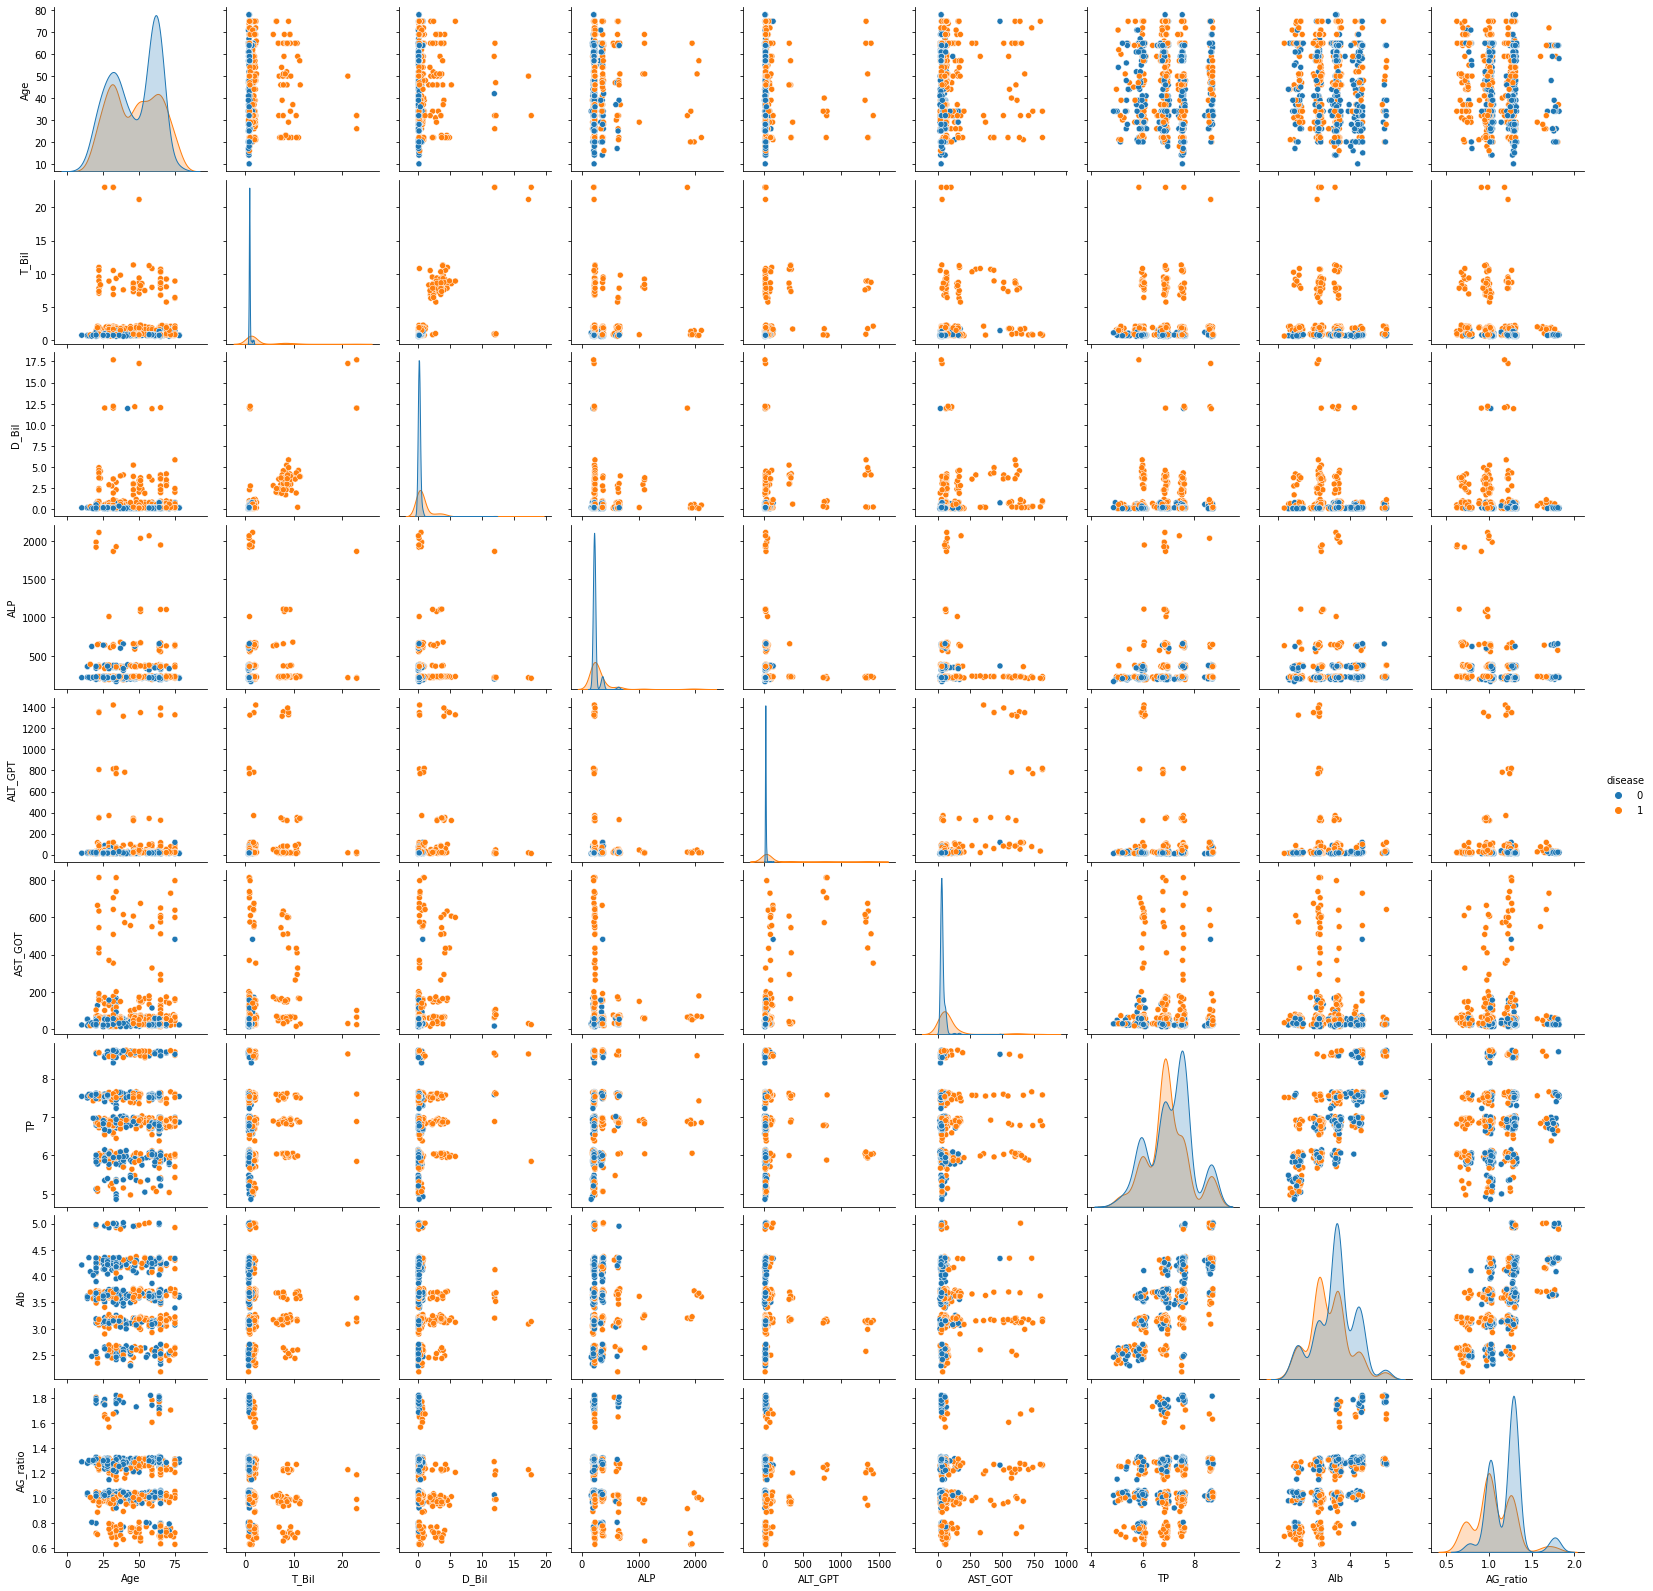

In [ ]:
sns.pairplot(train, hue="disease")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5f35d4cf8>,
      dtype=object)

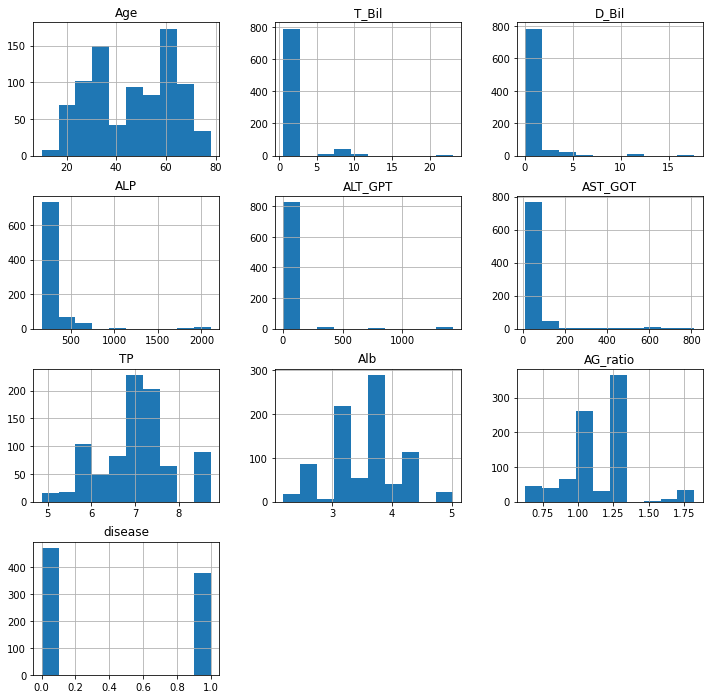

In [ ]:
train.hist(figsize=(12,12))

<Figure size 1080x1080 with 0 Axes>

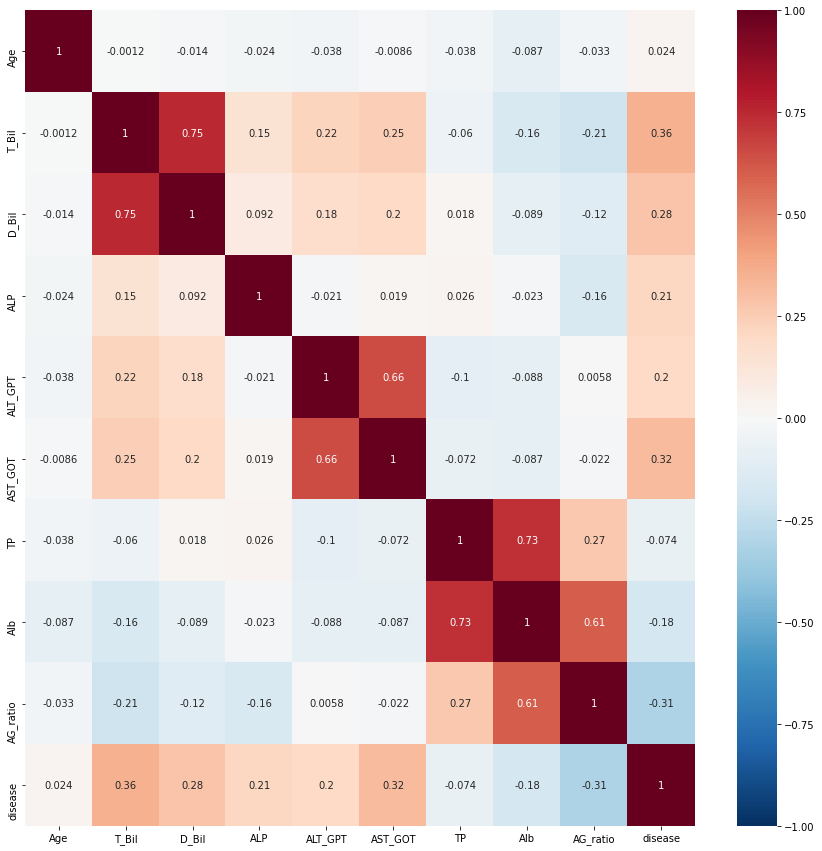

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdBu_r', annot = True)

In [ ]:
def preprocess(df):
    #カテゴリ変数の変換
    df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

    df['R_Bil']=df['T_Bil']-df['D_Bil']
    df['GOT_GPT']=df['AST_GOT']+df['ALT_GPT']
    df['TP_Alb']=df['TP']-df['Alb']
    df['AGr_Alb']=df['Alb']*(1+1/df['AG_ratio'])

    return df

In [ ]:
from sklearn.model_selection import  train_test_split
from sklearn.decomposition import PCA
train = preprocess(train)

#学習データとテストデータに分割
train_X = train.drop('disease',axis = 1)

# pca = PCA()
# pca.fit(train_X)

# train_X = pca.transform(train_X)
train_y = train.disease
(train_X , test_X , train_y , test_y) = train_test_split(train_X, train_y , test_size = 0.1 , random_state = 0)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's auc: 0.967128
[100]	valid_0's auc: 0.965975
[150]	valid_0's auc: 0.964821
[200]	valid_0's auc: 0.963091
Early stopping, best iteration is:
[106]	valid_0's auc: 0.968281


0.9682814302191465


Text(0.5, 1.0, 'ROC curve')

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

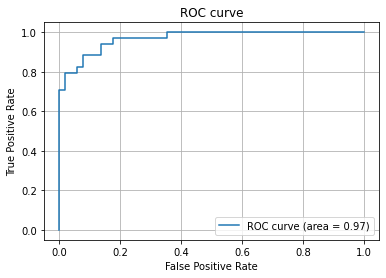

In [ ]:
import lightgbm as lgb
from sklearn.metrics import (roc_curve , auc ,accuracy_score)

lgb_train = lgb.Dataset(train_X, label=train_y)
lgb_eval = lgb.Dataset(test_X, label=test_y)

params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
    }

model = lgb.train(params,lgb_train,valid_sets=lgb_eval,verbose_eval=50,num_boost_round=1000,early_stopping_rounds=100)

# print(model.params)
# print(model.best_iteration)
# print(model.best_score)
model.save_model(dir+'lgbm_model.txt')

va_pred = model.predict(test_X, num_iteration=model.best_iteration)

fpr, tpr, thresholds = roc_curve(test_y , va_pred,pos_label = 1)
auc = auc(fpr,tpr)
print(auc)
# accuracy_score(pred,test_y)

# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

# pred = model.predict(pca.transform(preprocess(test)),num_iteration=model.best_iteration)
pred = model.predict(preprocess(test),num_iteration=model.best_iteration)

# df_pred = pd.Series(pred).map(lambda x: float(Decimal(str(x)).
#                             quantize(Decimal('0'), rounding=ROUND_HALF_UP))).astype(int)
df_pred = pd.Series(pred)

df_pred

0      0.000247
1      0.008880
2      0.000087
3      0.011253
4      0.003115
         ...   
345    0.655767
346    0.000102
347    0.000059
348    0.073594
349    0.036719
Length: 350, dtype: float64

In [ ]:
df_pred.to_csv(dir+'submit.csv',header=False)

In [ ]:
!ls

drive  sample_data
